# Experiment results

In [1]:
import yaml
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import re

from src.lib import plotting
importlib.reload(plotting)

cfg = plotting.get_config()

In [22]:
# os.listdir(cfg['experiment_directory'])

In [7]:
hist_baseline = plotting.load_hist("standard-scaler-baseline")
hist_baseline2 = plotting.load_hist("standard-scaling-no-time-1")
hist_min_max = plotting.load_hist("min-max-1")
hist_mixed_s1 = plotting.load_hist("mixed-preprocessing-test-1")
hist_mixed_s2 = plotting.load_hist("mixed-preprocessing-test-2")
hist_mixed_kl1 = plotting.load_hist("mixed-preprocessing-test-kl-9")
hist_mixed_kl2 = plotting.load_hist("mixed-preprocessing-test-kl-30")
hist_edain = plotting.load_hist("edain-preprocessing-1")

hist_nothing = plotting.load_hist("no-preprocess-1")

(0.2, 0.23)

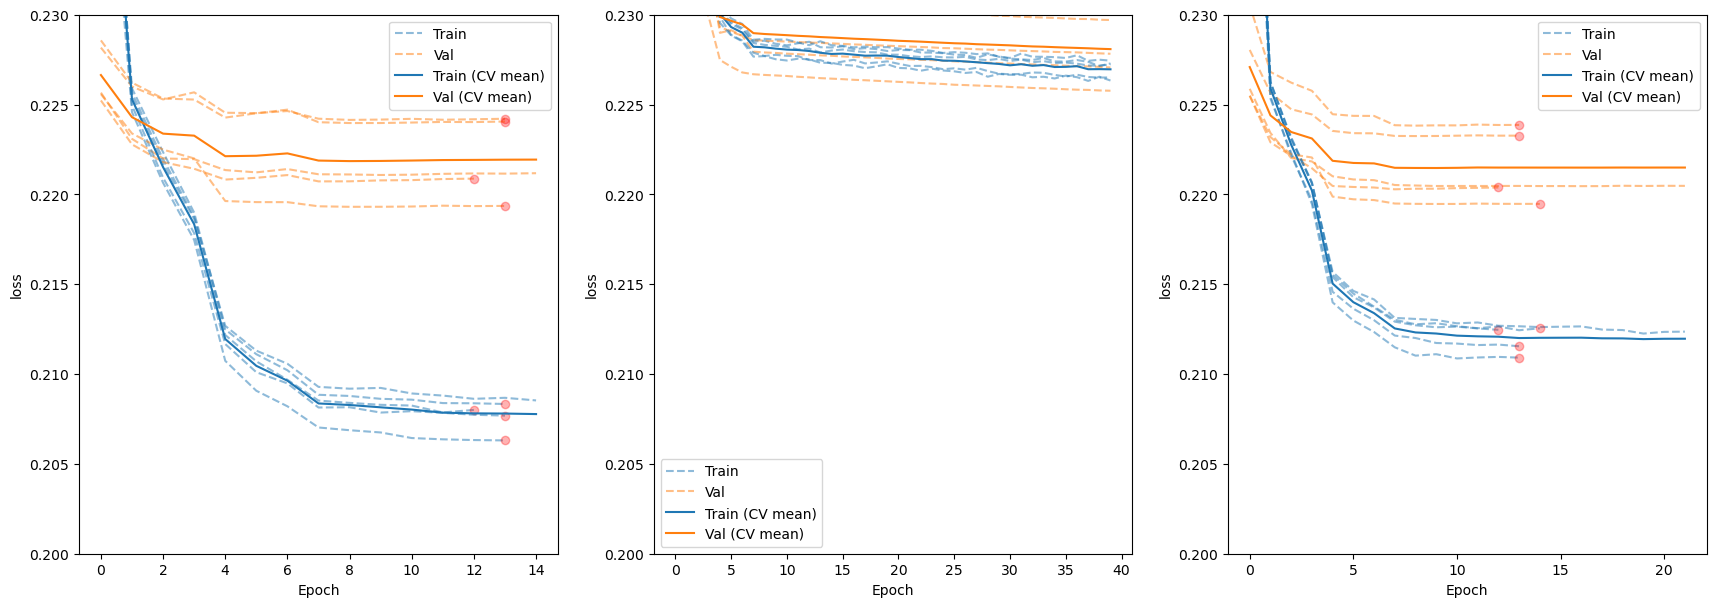

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(21, 7))
plotting.plot_cv(hist_baseline, "loss", axs[0])
plotting.plot_cv(hist_min_max, "loss", axs[1])
plotting.plot_cv(hist_mixed, "loss", axs[2])
axs[0].set_ylim([0.20, 0.23])
axs[1].set_ylim([0.20, 0.23])
axs[2].set_ylim([0.20, 0.23])

In [8]:
def compare_hists(histories, labels, key, ax, cols=None):
    if cols is None:
        cols = ['pink', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'black', 'grey']
    assert len(histories) <= len(cols) and "Not enough colours specified"
    
    for hist, c, l in zip(histories, cols, labels):
        cv_avgs = plotting.get_average(hist, key)
        ax.plot(cv_avgs, label = f"{l} ({cv_avgs[-1]:.4f})", color=c, alpha=1)
        ax.plot(len(cv_avgs) - 1, cv_avgs[-1], marker='o', color=c)
    ax.legend(title=f"Preprocessing method ({key})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(key)

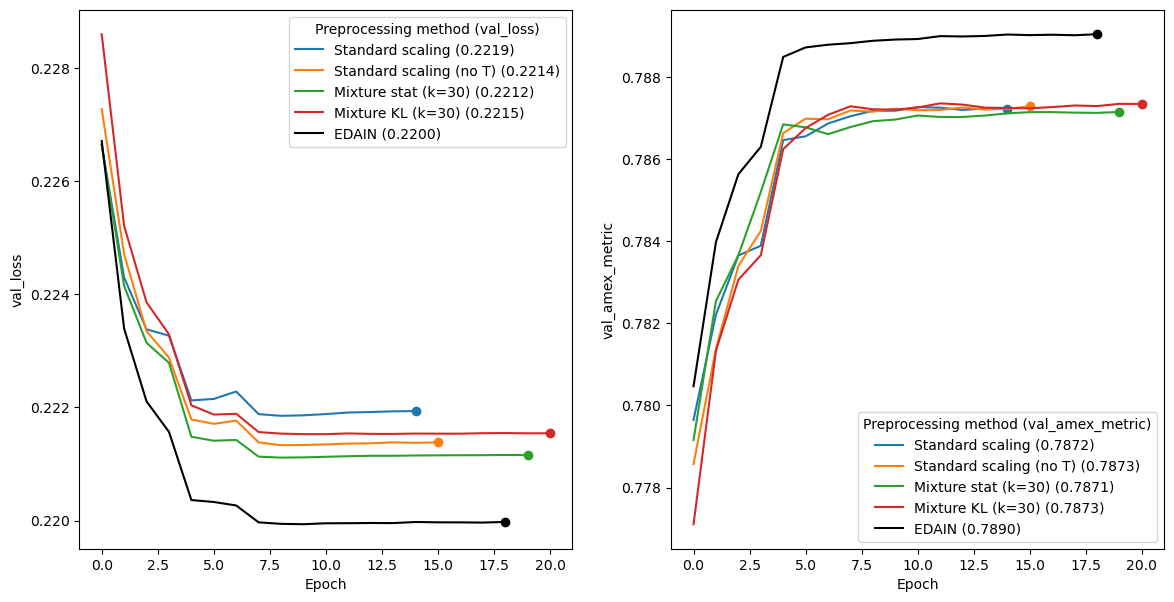

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
compare_hists(
    [hist_baseline,      hist_baseline2,                   hist_mixed_s2, hist_mixed_kl2, hist_edain],
    ["Standard scaling", "Standard scaling (no T)", "Mixture stat (k=30)", "Mixture KL (k=30)", "EDAIN"],
    "val_loss",
    axs[0])
compare_hists(
    [hist_baseline,      hist_baseline2,                   hist_mixed_s2, hist_mixed_kl2, hist_edain],
    ["Standard scaling", "Standard scaling (no T)", "Mixture stat (k=30)", "Mixture KL (k=30)", "EDAIN"],
    "val_amex_metric",
    axs[1])

## Learning rate tuning

In [18]:
def get_best_hist_cfg(exp_name):
    files = [f for f in os.listdir(cfg['experiment_directory']) if re.match(re.escape(exp_name) + r'-\d+.*', f)]
    best_vloss = float("inf")
    ret_hist = None
    for f in files:
        # remove the .npy ending
        hist = plotting.load_hist(f[:-4])
        if hist['val_loss'][0][-1] < best_vloss:
            best_vloss = hist['val_loss'][0][-1]
            ret_hist = hist
    return ret_hist

# optimal DAIN parameters
hist = get_best_hist_cfg("dain-tuning")
print(hist['experiment_config']['dain'])
print(f"Final validation loss: {hist['val_loss'][0][-1]:.4f}")

{'mode': 'adaptive_scale', 'mean_lr': 1.0, 'scale_lr': 1.0, 'gate_lr': 0.001, 'input_dim': 177}
Final validation loss: 0.2216


In [19]:
# optimal BiN parameters
hist = get_best_hist_cfg("bin-tuning")
print(hist['experiment_config']['bin'])
print(f"Final validation loss: {hist['val_loss'][0][-1]:.4f}")

{'beta_lr': 10.0, 'gamma_lr': 1.0, 'lambda_lr': 1e-06, 'base_lr': 0.001}
Final validation loss: 0.2234


## Comparing number of clusters for mixture

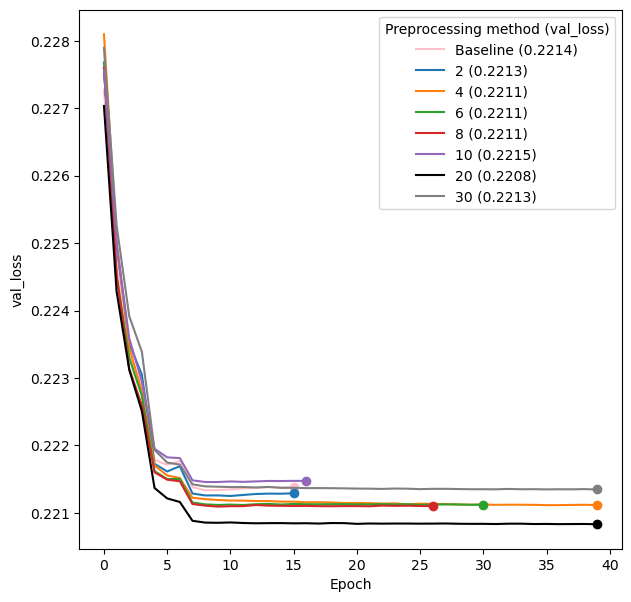

In [9]:
num_clusters = [2, 4, 6, 8, 10, 20, 30]

histories = []
for i in range(len(num_clusters)):
    histories.append(plotting.load_hist(f"mixture-clustering-tuning-{i}"))

fig, ax = plt.subplots(figsize=(7, 7))
compare_hists([hist_baseline2] + histories, ["Baseline"] + num_clusters, "val_loss", ax)

## LOB FI-2010 dataset

In [102]:
hist = plotting.load_hist("lob-test-tuning")
hist['split_results'][0][0].keys()

dict_keys(['accuracy', 'precision', 'recall', 'f1', 'precision_avg', 'recall_avg', 'f1_avg', 'kappa', 'val_loss', 'train_loss'])

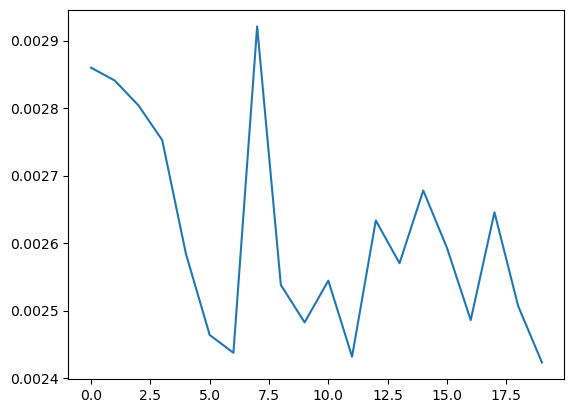

In [45]:
# This is a plot of the training loss with base_lr=1e-5 and milestone lr step at epoch 6
plt.plot([x['train_loss'] for x in hist['split_results'][0]])

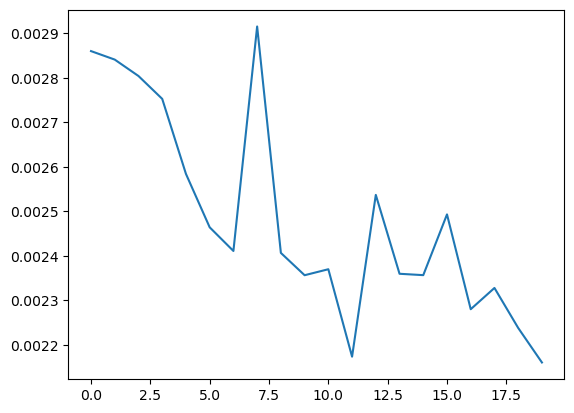

In [47]:
# This is a plot of the training loss with base_lr=1e-5 and no scheduling...
plt.plot([x['train_loss'] for x in hist['split_results'][0]])

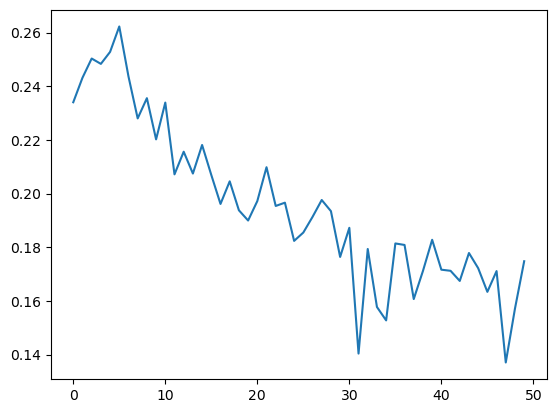

In [59]:
plt.plot([x['kappa'] for x in hist['split_results'][0]])

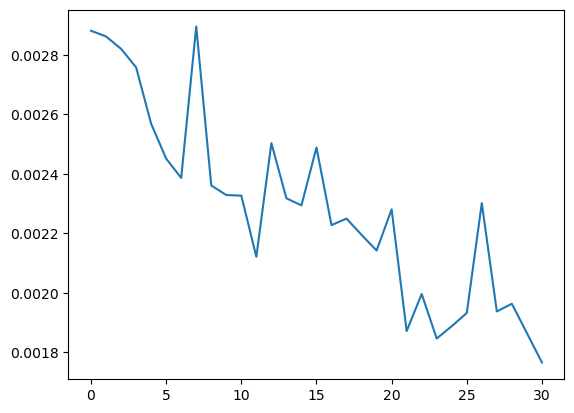

In [64]:
plt.plot([x['train_loss'] for x in hist['split_results'][0]])

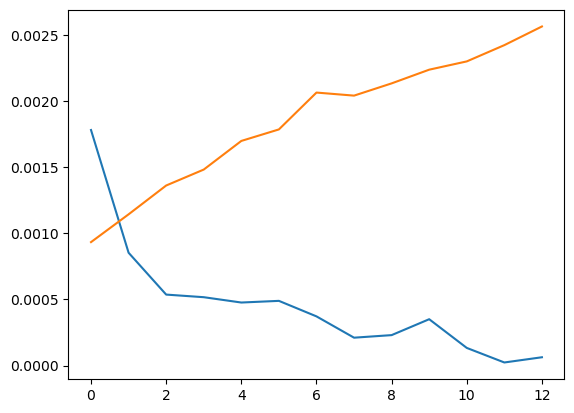

In [72]:
# using lr=1e-3 with steps at 10 and 20
plt.plot([x['train_loss'] for x in hist['split_results'][0]])
plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

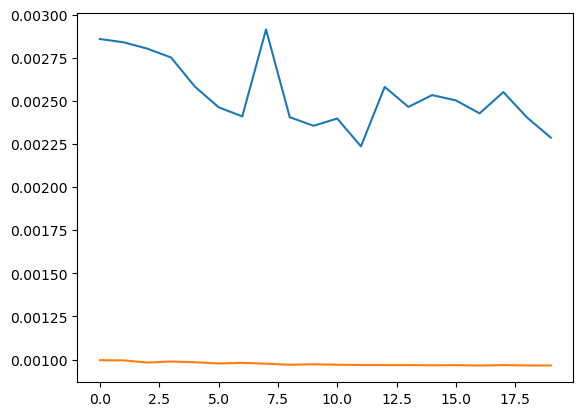

In [83]:
plt.plot([x['train_loss'] for x in hist['split_results'][0]])
plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

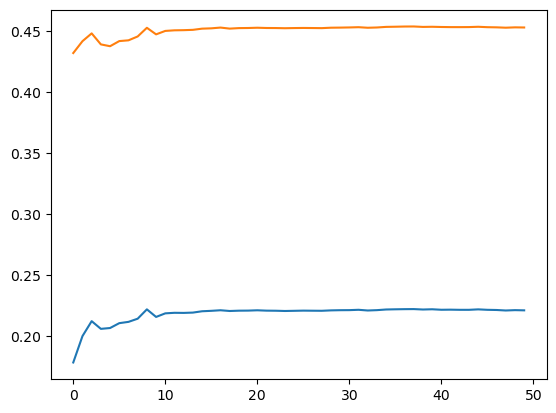

In [87]:
# This is using Adam optimizer, with base_lr 1e-5 and steps at 10 and 20
#   and also not using any early stopping
plt.plot([x['kappa'] for x in hist['split_results'][0]])
plt.plot([x['f1_avg'] for x in hist['split_results'][0]])
#plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

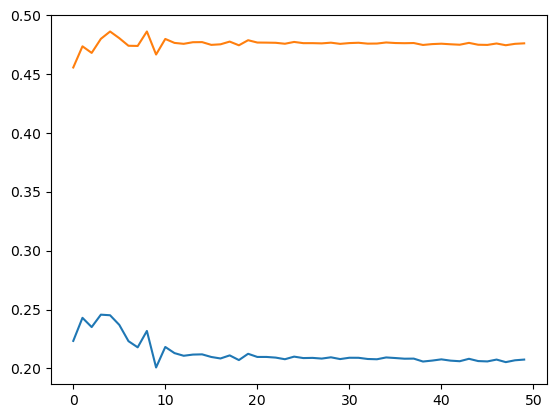

In [89]:
# This is using Adam optimizer, with base_lr 1e-4 and steps at 10 and 20
#   and also not using any early stopping
plt.plot([x['kappa'] for x in hist['split_results'][0]])
plt.plot([x['f1_avg'] for x in hist['split_results'][0]])
#plt.plot([x['val_loss'] / 1024 for x in hist['split_results'][0]])

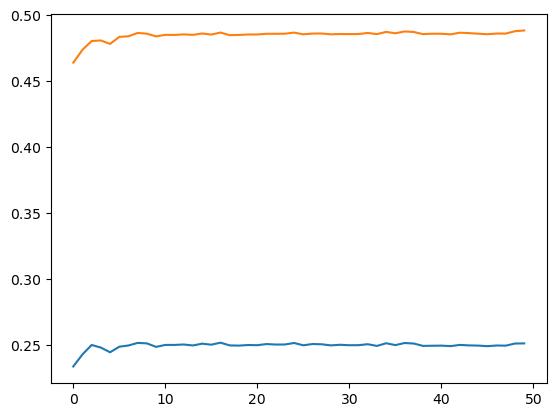

In [103]:
# using rmsprop with milestones 4 and 8, early stopping and lr=1e-4
plt.plot([x['kappa'] for x in hist['split_results'][0]])
plt.plot([x['f1_avg'] for x in hist['split_results'][0]])

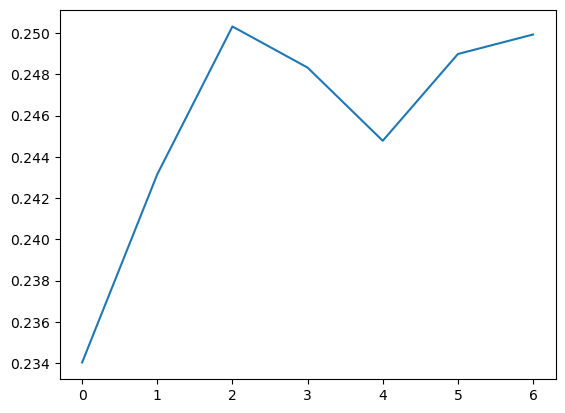

In [101]:
plt.plot([x['kappa'] for x in hist['split_results'][0]])
#plt.plot([x['f1_avg'] for x in hist['split_results'][0]])

In [75]:
hist_bin = plotting.load_hist("lob-bin-experiment")
hist_dain = plotting.load_hist("lob-dain-experiment")
hist_baseline = plotting.load_hist("lob-standard-scaler-experiment")
hist_baseline['split_results'][0][0].keys()

dict_keys(['accuracy', 'precision', 'recall', 'f1', 'precision_avg', 'recall_avg', 'f1_avg', 'kappa', 'val_loss', 'train_loss'])

In [79]:
def get_res(hist, key):
    vals = []
    for i in range(len(hist['split_results'])):
        vals.append(hist['split_results'][i][-1][key])
    return f"{np.mean(vals):.4f} +- {1.96 * np.std(vals):.4f}"
    
get_res(hist_bin, "f1_avg"), get_res(hist_dain, "f1_avg"), get_res(hist_baseline, "f1_avg")

('0.5441 +- 0.0425', '0.5574 +- 0.0332', '0.5021 +- 0.0416')

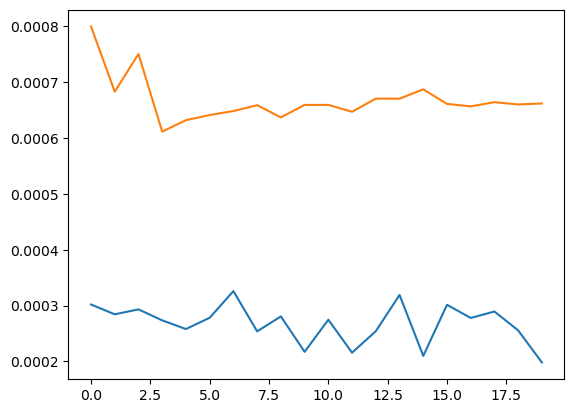

In [81]:
plt.plot([x['train_loss'] for x in hist_dain['split_results'][6]])
plt.plot([x['val_loss'] / 1024 for x in hist_dain['split_results'][6]])